In [1]:
# model_analysis.ipynb

import os
import requests
import time
import tensorflow as tf
import numpy as np
import yaml
import shutil
from PIL import Image

API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
DOWNLOADS = os.path.join(os.path.expanduser("~"), "Downloads")

def create_model(units):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(units, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def save_images_per_class(x, y, base_folder):
    os.makedirs(base_folder, exist_ok=True)
    class_counts = {i: 0 for i in range(10)}
    for class_idx in range(10):
        os.makedirs(os.path.join(base_folder, f"class_{class_idx}"), exist_ok=True)
    for i in range(len(x)):
        label = int(y[i])
        img_uint8 = (x[i] * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8)
        img_path = os.path.join(base_folder, f"class_{label}", f"image_{class_counts[label]}.png")
        img_pil.save(img_path)
        class_counts[label] += 1

# Dummy dataset (small, fixed)
x = np.random.rand(100, 32, 32, 3).astype(np.float32)
y = np.random.randint(0, 10, 100).astype(np.int64)
dataset_folder = os.path.join(DOWNLOADS, "model_analysis_dataset")
save_images_per_class(x, y, dataset_folder)

# YAML definition (unchanged)
yaml_path = os.path.join(DOWNLOADS, "model_analysis_definition.yaml")
dataset_definition = {
    "type": "image",
    "image_size": [32, 32],
    "input_shape": [32, 32, 3],
    "output_shape": [10],
    "preprocessing": {"normalize": True}
}
with open(yaml_path, "w") as f:
    yaml.dump(dataset_definition, f)

# Model sizes to test
model_units = [8, 32, 128]
job_ids = []

for units in model_units:
    model = create_model(units)
    model_path = os.path.join(DOWNLOADS, f"model_analysis_{units}.keras")
    model.save(model_path)

    # Zip dataset (simulate image dataset)
    shutil.make_archive(dataset_folder, 'zip', dataset_folder)
    dataset_zip = dataset_folder + ".zip"

    files = {
        "model": open(model_path, "rb"),
        "dataset": open(dataset_zip, "rb"),
        "dataset_definition": open(yaml_path, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"test_model_{units}",
        "epochs": 1,
    }
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted model with {units} units: {response.status_code} {response.text}")
    job_id = response.json().get("job_id")
    job_ids.append(job_id)

# Wait for jobs to finish and download artifacts as in epoch_analysis.ipynb

Submitted model with 8 units: 200 {"job_id":"b0b9ca30-72ae-48ac-99c3-9aef0a13a98b","status":"Training started","unique_dir":"fd625b0b-6af0-40d2-936b-344458ea06c0"}
Submitted model with 32 units: 200 {"job_id":"1413bd3f-9fa7-4cef-9c51-a6d786fd1dee","status":"Training started","unique_dir":"d4cd2330-2c81-490f-b0f9-e9d84a07b2c8"}
Submitted model with 128 units: 200 {"job_id":"5de6f378-c0d8-4319-a16f-36be72bfbb48","status":"Training started","unique_dir":"c752e65f-fa24-4545-b8dc-ad8056a32e6e"}


Download the job folders from MinIO for analysis !!

   Model Units  Dataset Size (KB)  Definition Size (KB)  \
0            8         322.326172               0.12207   
1           32         322.326172               0.12207   
2          128         322.326172               0.12207   

   Input Model Size (KB)  Trained Model Size (KB)  AIBOM Size (KB)  \
0             302.291992               864.278320        13.231445   
1            1148.679688              3403.416016        13.233398   
2            4534.182617             13559.918945        13.235352   

   Logs Size (KB)  Metrics Size (KB)  RunLink Size (KB)  \
0        4.251953           0.104492           1.290039   
1        4.251953           0.104492           1.291016   
2        4.251953           0.103516           1.291992   

   Total Job Folder Size (KB)  AIBOM % of Trained Model  
0                 1507.896484                  1.530924  
1                 4893.424805                  0.388827  
2                18435.432617                  0.097606  


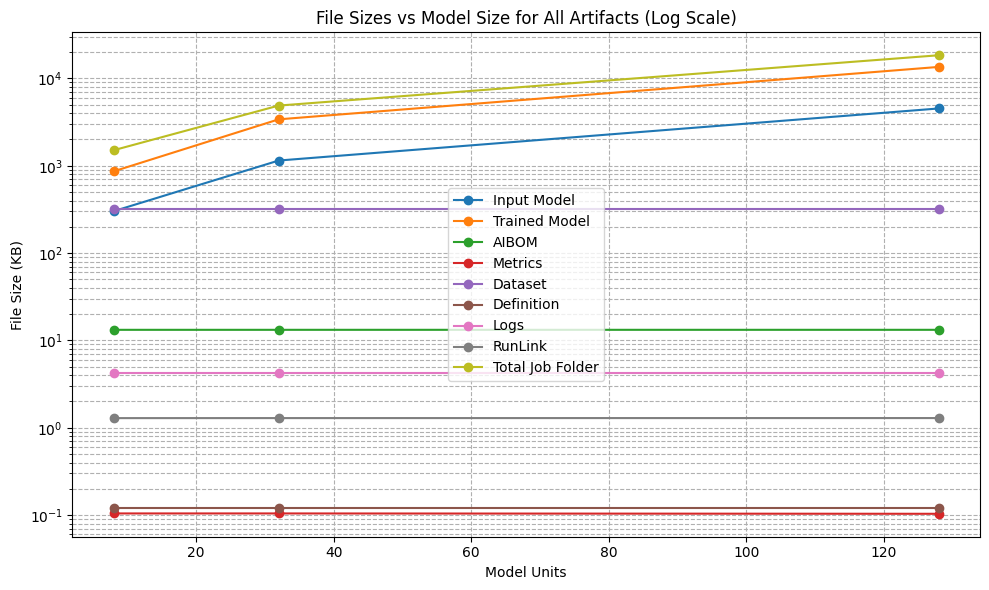

In [9]:
# --- Analysis of artifact sizes for increasing model sizes ---

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# List your downloaded job folders here (update with actual folder names)
model_units = [8, 32, 128]
job_folders = [
    "fd625b0b-6af0-40d2-936b-344458ea06c0",    # replace with actual folder name for 8 units
    "d4cd2330-2c81-490f-b0f9-e9d84a07b2c8",   # replace with actual folder name for 32 units
    "c752e65f-fa24-4545-b8dc-ad8056a32e6e",  # replace with actual folder name for 128 units
]

DOWNLOADS = Path.home() / "Downloads"

input_model_sizes = []
trained_model_sizes = []
aibom_sizes = []
dataset_sizes = []
definition_sizes = []
logs_sizes = []
metrics_sizes = []
runlink_sizes = []
total_folder_sizes = []

for units, folder in zip(model_units, job_folders):
    folder_path = DOWNLOADS / folder
    dataset_file = folder_path / "dataset" / "model_analysis_dataset.zip"
    definition_file = folder_path / "definition"  / "model_analysis_definition.yaml"
    input_model_file = folder_path / "model" / f"model_analysis_{units}.keras"
    output_path = folder_path / "output"
    trained_model_file = output_path / "trained_model.keras"
    aibom_file = output_path / "cyclonedx_bom.json"
    logs_file = output_path / "logs.log"
    metrics_file = output_path / "metrics.json"
    runlink_file = next(output_path.glob("run_training.*.link"), None)

    dataset_sizes.append(dataset_file.stat().st_size / 1024 if dataset_file.exists() else None)
    definition_sizes.append(definition_file.stat().st_size / 1024 if definition_file.exists() else None)
    input_model_sizes.append(input_model_file.stat().st_size / 1024 if input_model_file.exists() else None)
    trained_model_sizes.append(trained_model_file.stat().st_size / 1024 if trained_model_file.exists() else None)
    aibom_sizes.append(aibom_file.stat().st_size / 1024 if aibom_file.exists() else None)
    logs_sizes.append(logs_file.stat().st_size / 1024 if logs_file.exists() else None)
    metrics_sizes.append(metrics_file.stat().st_size / 1024 if metrics_file.exists() else None)
    runlink_sizes.append(runlink_file.stat().st_size / 1024 if runlink_file and runlink_file.exists() else None)

    # Calculate total folder size in KB
    total_size = sum(f.stat().st_size for f in folder_path.rglob('*') if f.is_file()) / 1024
    total_folder_sizes.append(total_size)

df = pd.DataFrame({
    "Model Units": model_units,
    "Dataset Size (KB)": dataset_sizes,
    "Definition Size (KB)": definition_sizes,
    "Input Model Size (KB)": input_model_sizes,
    "Trained Model Size (KB)": trained_model_sizes,
    "AIBOM Size (KB)": aibom_sizes,
    "Logs Size (KB)": logs_sizes,
    "Metrics Size (KB)": metrics_sizes,
    "RunLink Size (KB)": runlink_sizes,
    "Total Job Folder Size (KB)": total_folder_sizes,
    "AIBOM % of Trained Model": [100 * a / m if m else None for a, m in zip(aibom_sizes, trained_model_sizes)]
})
print(df)

plt.figure(figsize=(10,6))
plt.plot(df["Model Units"], df["Input Model Size (KB)"], marker='o', label="Input Model")
plt.plot(df["Model Units"], df["Trained Model Size (KB)"], marker='o', label="Trained Model")
plt.plot(df["Model Units"], df["AIBOM Size (KB)"], marker='o', label="AIBOM")
plt.plot(df["Model Units"], df["Metrics Size (KB)"], marker='o', label="Metrics")
plt.plot(df["Model Units"], df["Dataset Size (KB)"], marker='o', label="Dataset")
plt.plot(df["Model Units"], df["Definition Size (KB)"], marker='o', label="Definition")
plt.plot(df["Model Units"], df["Logs Size (KB)"], marker='o', label="Logs")
plt.plot(df["Model Units"], df["RunLink Size (KB)"], marker='o', label="RunLink")
plt.plot(df["Model Units"], df["Total Job Folder Size (KB)"], marker='o', label="Total Job Folder")

plt.xlabel("Model Units")
plt.ylabel("File Size (KB)")
plt.title("File Sizes vs Model Size for All Artifacts (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
